In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

import warnings
warnings.filterwarnings(action='ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data Loading (pre-processed data)

In [2]:
org_df = pd.read_csv("./preprocessed_data.csv", parse_dates=["Timestamp"])
train_df = org_df[org_df.answer != -1]
test_df = org_df[org_df.answer == -1]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2525956 entries, 0 to 2526699
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user              int64         
 1   assessmentItemID  object        
 2   testId            object        
 3   answer            int64         
 4   Timestamp         datetime64[ns]
 5   tag               int64         
 6   label             object        
 7   category          int64         
 8   test              int64         
 9   item              int64         
 10  month             int64         
 11  day               int64         
 12  weekday           int64         
 13  hour              int64         
 14  elapsed           float64       
 15  test_elapsed      float64       
dtypes: datetime64[ns](1), float64(2), int64(10), object(3)
memory usage: 327.6+ MB


# 항목별 기본 통계

In [3]:
num_users = train_df.user.nunique()
num_probs = train_df.assessmentItemID.nunique()
num_categories = train_df.category.nunique()
num_tests = train_df.testId.nunique()
num_tags = train_df.tag.nunique()

print(f"# of users: {num_users}")
print(f"# of probs: {num_probs}")
print(f"# of categories: {num_categories}")
print(f"# of test: {num_tests}")
print(f"# of tags: {num_tags}")

# of users: 7442
# of probs: 9454
# of categories: 9
# of test: 1537
# of tags: 912


In [4]:
sum(train_df.user.unique() == np.arange(7442))

7442

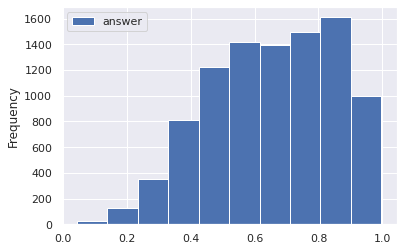

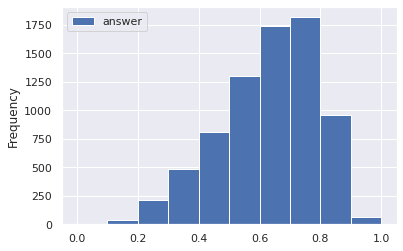

In [5]:
prob_acc = train_df.groupby("assessmentItemID").agg({"answer": "mean"})
prob_acc.plot.hist()

user_acc = train_df.groupby("user").agg({"answer": "mean"})
user_acc.plot.hist()

In [6]:
train_df.groupby("testId").agg({"tag": "nunique"}).describe()

,tag
count,1537.000000
mean,1.741705
std,1.181580
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


## user에 대한 feature engineering

In [7]:
user_group = train_df.groupby("user")
agg_on_user = user_group.agg({"category": "nunique",
                              "tag": "nunique",
                              "testId": "nunique",
                              "assessmentItemID": "nunique",
                              "answer": "mean",
                              
                              "Timestamp": "count"
                             })

agg_on_user.rename(columns={"Timestamp": "trials"}, inplace=True)
# user_group["mean_trails"] = agg_on_user.trials / agg_o

In [8]:
agg_on_user["mean_trials"] = agg_on_user["trials"] / agg_on_user["assessmentItemID"]
agg_on_user[agg_on_user["mean_trials"] > 1.0].sort_values("mean_trials", ascending=False)

,category,tag,testId,assessmentItemID,answer,trials,mean_trials
user,,,,,,,
165,1,83,68,475,0.445471,1082,2.277895
354,1,71,74,517,0.755328,1173,2.268859
517,1,138,72,547,0.217158,1119,2.045704
2334,1,74,54,373,0.560305,655,1.756032
693,1,150,71,569,0.244560,965,1.695958
...,...,...,...,...,...,...,...
86,2,127,115,650,0.719084,655,1.007692
1055,2,88,128,664,0.736921,669,1.007530
2226,2,109,144,837,0.801898,843,1.007168


In [9]:
user_cat_group = train_df.groupby(["user", "category"])
agg_on_user_cat = user_cat_group.agg({"tag": "nunique",
                                      "testId": "nunique",
                                      "assessmentItemID": "nunique",
                                      "answer": "mean",
                                      
                                      "Timestamp": "count"
                                     })
agg_on_user_cat.rename(columns={"Timestamp": "trials"}, inplace=True)
agg_on_user_cat

tag  testId  assessmentItemID    answer  trials
user category                                                 
0    2           8       6                36  0.722222      36
     6          61      50               346  0.791908     346
     8          96      48               363  0.468320     363
1    4          80     102               527  0.822719     581
     9          75      51               352  0.903409     352
...            ...     ...               ...       ...     ...
7439 4           4       3                15  0.733333      15
7440 3           3       2                10  0.400000      10
     5           3       1                 5  0.400000       5
7441 3           1       1                 5  0.200000       5
     4           1       1                 4  1.000000       4

[19739 rows x 5 columns]

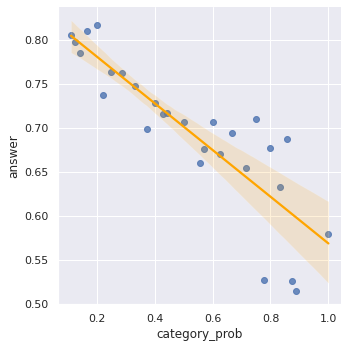

In [10]:
tmp = train_df.groupby(["user"]).agg({"category": "max"})
tmp.rename(columns={"category": "max_category"}, inplace=True)

tmp_df = train_df.copy()
tmp_df = pd.merge(tmp_df, tmp, on="user", how="left")
tmp_df["category_prob"] = tmp_df["category"] / tmp_df["max_category"]
agg_on_cat_prob = tmp_df.groupby("category_prob").agg({"answer": "mean"}).reset_index()
sns.lmplot(x="category_prob", y="answer", data=agg_on_cat_prob, line_kws={"color": "orange"})

(array([1.]), <matplotlib.axes._subplots.AxesSubplot at 0x7fd3a5d1bfd0>)

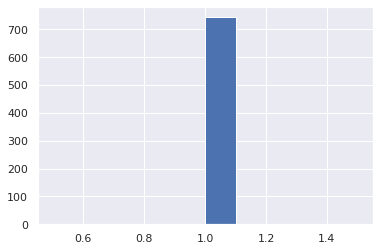

In [11]:
tmp = test_df.groupby(["user"]).agg({"category": "max"})
tmp.rename(columns={"category": "max_category"}, inplace=True)

tmp_df = test_df.copy()
tmp_df = pd.merge(tmp_df, tmp, on="user", how="left")
tmp_df["category_prob"] = tmp_df["category"] / tmp_df["max_category"]
tmp_df["category_prob"].unique(), tmp_df["category_prob"].hist()

## assessmentItemID에 대한 features

In [12]:
item_group = train_df.groupby("assessmentItemID")
agg_on_item = item_group.agg({"user": "nunique",
                              "answer": "mean",
                              
                              "Timestamp": "count"
                             })

agg_on_item.rename(columns={"Timestamp": "trials"}, inplace=True)
agg_on_item
# user_group["mean_trails"] = agg_on_user.trials / agg_o

,user,answer,trials
assessmentItemID,,,
A010001001,343,0.922857,350
A010001002,343,0.960000,350
A010001003,343,0.905714,350
A010001004,343,0.945714,350
A010001005,343,0.882857,350
...,...,...,...
A090074002,50,0.480000,50
A090074003,50,0.580000,50
A090074004,50,0.360000,50


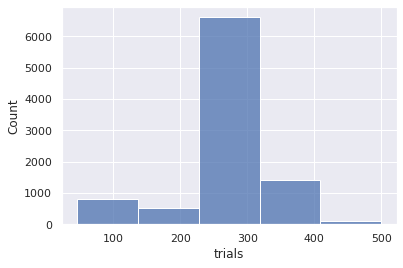

In [13]:
# sns.lmplot(x="trials", y="answer", data=agg_on_item)
sns.histplot(x="trials", data=agg_on_item, bins=5)

## tag에 대한 features

In [14]:
tmp = train_df.groupby("tag").agg({"Timestamp": ["count", "nunique"]})
tmp["tag_mean_trials"] = tmp["Timestamp"]["count"] / tmp["Timestamp"]["nunique"]
tmp = tmp.drop(columns=["Timestamp"])
tmp.columns = tmp.columns.droplevel(1)
tmp.columns

Index(['tag_mean_trials'], dtype='object')

In [15]:
tag_group = train_df.groupby("tag")
agg_on_tag = tag_group.agg({"category": lambda x: int(str(x.unique()[0])),
                            "testId": "nunique",
                            "assessmentItemID": "nunique",
                            "answer": "mean",
                            
                            "Timestamp": "count"
                           })

agg_on_tag.rename(columns={"Timestamp": "trials"}, inplace=True)
agg_on_tag["mean_trials"] = agg_on_tag.trials / agg_on_tag.assessmentItemID
agg_on_tag.columns

Index(['category', 'testId', 'assessmentItemID', 'answer', 'trials',
       'mean_trials'],
      dtype='object')

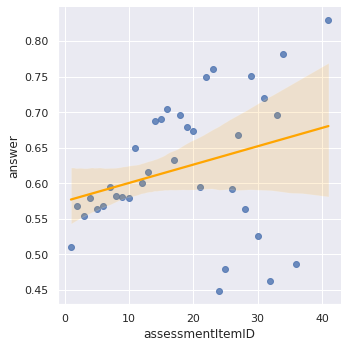

In [16]:
# tag의 노출 빈도(문제 개수)에 따른 정답률
tag_item_group = agg_on_tag.groupby(["assessmentItemID"]).agg({"answer": "mean"}).reset_index()
sns.lmplot(x="assessmentItemID", y="answer", data=tag_item_group, line_kws={"color": "orange"})

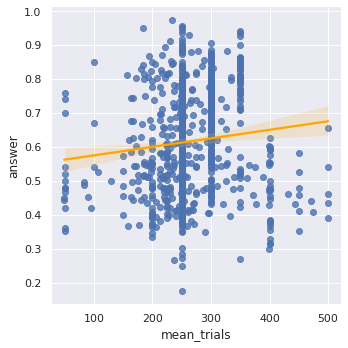

In [17]:
# tag에 대하여 학생들이 푼 횟수에 따른 정답률
sns.lmplot(x="mean_trials", y="answer", data=agg_on_tag, line_kws={"color": "orange"})

In [18]:
# tag, category 별로 => 큰 상관관계는 없어보임
# for cat in range(1, 10):
#     sns.lmplot(x="trials", y="answer",
#                data=agg_on_tag[agg_on_tag.category == cat], 
#                line_kws={'color': 'orange'})


In [19]:
num_tags, num_tests

(912, 1537)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 12]), array([115, 149, 498,  63,  43,  26,   8,   5,   3,   2]))


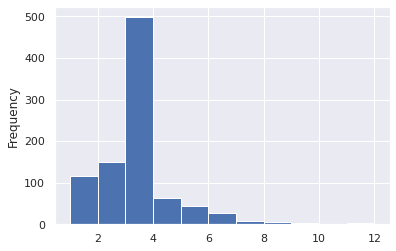

In [20]:
# 한개의 tag는 대체로 1 ~ 4개 정도의 test에 속한다
print(np.unique(agg_on_tag.testId, return_counts=True))
agg_on_tag.testId.plot.hist(bins=11)

## testId에 대한 feature engineering

In [21]:
agg_on_test = train_df.groupby(["testId"]).agg({"assessmentItemID": "nunique",
                                                "tag": "nunique",
                                                "answer": "mean"
                                               })
agg_on_test

,assessmentItemID,tag,answer
testId,,,
A010000001,5,1,0.923429
A010000002,5,2,0.931429
A010000003,5,3,0.842857
A010000004,5,3,0.880571
A010000005,5,2,0.849143
...,...,...,...
A090000070,8,4,0.461153
A090000071,8,5,0.345000
A090000072,6,2,0.453333


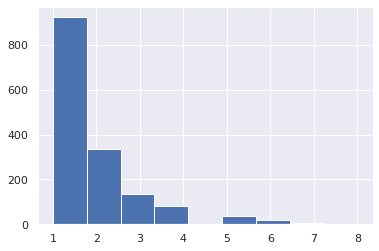

In [22]:
# 시험지 별 tag 개수에 따른 정답률
agg_on_test_tag = train_df.groupby("testId").agg({"tag": "nunique", "answer": "mean"})
agg_on_test_tag.tag.hist(bins=9)

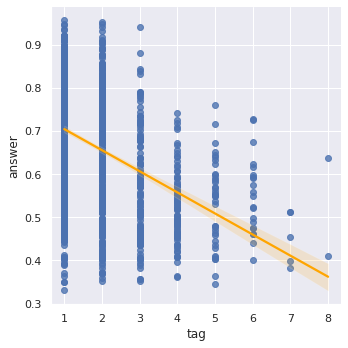

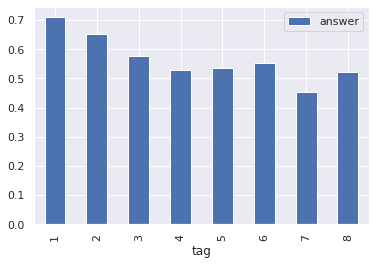

In [23]:
# 시험지 별 tag 개수에 따른 정답률
sns.lmplot(x="tag", y="answer", data=agg_on_test_tag, line_kws={"color": "orange"})
agg_on_test_tag.groupby(["tag"]).agg({"answer": "mean"}).plot.bar()

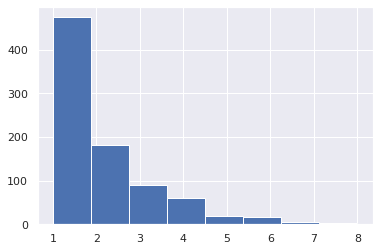

In [24]:
valid_df = train_df[(train_df.user != train_df.user.shift(-1)) &
                    (train_df.label == "train")]
agg_on_test_tag[agg_on_test_tag.index.isin(valid_df["testId"].unique())].tag.hist(bins=8)

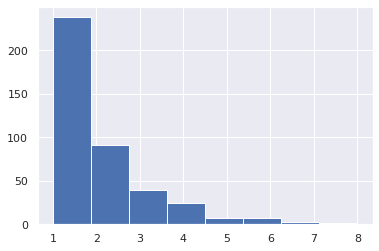

In [25]:
# test 데이터의 시험지 특징()
agg_on_test_tag[agg_on_test_tag.index.isin(test_df["testId"].unique())].tag.hist(bins=8)
# np.unique(agg_on_test_tag[agg_on_test_tag.index.isin(test_df["testId"].unique())].tag, return_counts=True)

## category에 대한 features

In [26]:
cat_group = train_df.groupby("category")
agg_on_cat = cat_group.agg({"tag": "nunique",
                            "testId": "nunique",
                            "assessmentItemID": "nunique",
                            "answer": "mean",
                            "Timestamp": "count"
                           })
agg_on_cat.rename(columns={"Timestamp": "trials"}, inplace=True)
agg_on_cat["mean_trials"] = agg_on_cat.trials / agg_on_cat.assessmentItemID
agg_on_cat

,tag,testId,assessmentItemID,answer,trials,mean_trials
category,,,,,,
1,64,192,975,0.801686,303675,311.461538
2,70,194,1022,0.738023,297263,290.863992
3,85,198,1060,0.702210,303365,286.193396
4,81,198,1031,0.680256,300403,291.370514
5,98,193,1266,0.659098,306317,241.956556
6,93,186,1213,0.712279,296284,244.257214
7,176,164,1322,0.521761,315177,238.409228
8,150,138,1050,0.500826,271841,258.896190
9,96,74,515,0.454680,131631,255.594175


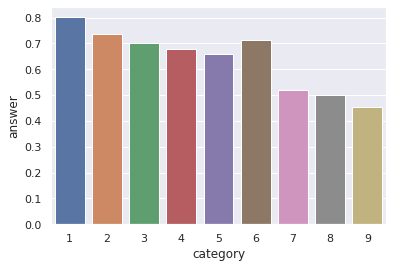

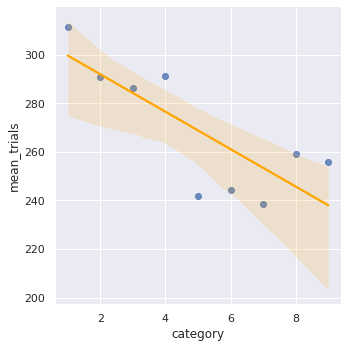

In [27]:
sns.barplot(x="category", y="answer", data=agg_on_cat.reset_index())
sns.lmplot(x="category", y="mean_trials", data=agg_on_cat.reset_index(), line_kws={'color': 'orange'})

## 유사한 tag끼리 묶기(같은 시험에 등장하는 tag들끼리 묶기) => chapter

In [28]:
num_tags, train_df.tag.nunique()

(912, 912)

In [29]:
tags_by_test = train_df.groupby(["testId"]).agg({"tag": lambda x: set(x.unique())})
tags_by_test.columns = ["knowledgeTagSet"]

In [30]:
tag_set_by_test = tags_by_test.knowledgeTagSet.values
chapter = [tag_set_by_test[0]]
for tags in tag_set_by_test[1:]:
    is_in_group = False
    for idx, chap in enumerate(chapter):
        if tags & chap:
            chapter[idx] = chap | tags
            is_in_group = True
    if not is_in_group:
        chapter.append(tags)
        
len(chapter)

461

In [31]:
chapter_dict = {}
for idx, tags in enumerate(chapter):
    for tag in tags:
        chapter_dict[tag] = idx
len(chapter_dict.keys())

912

In [32]:
train_df["chapter"] = train_df.tag.apply(lambda x: chapter_dict[x])

In [33]:
agg_on_chapter = train_df.groupby(["chapter"]).agg({"testId": "nunique",
                                                    "assessmentItemID": "nunique",
                                                    "tag": "nunique",
                                                    "answer": "mean",
                                                    
                                                    "Timestamp": "count"})
agg_on_chapter.rename(columns={"Timestamp": "trials"}, inplace=True)
agg_on_chapter["mean_trials"] = agg_on_chapter["trials"] / agg_on_chapter["assessmentItemID"]
agg_on_chapter

,testId,assessmentItemID,tag,answer,trials,mean_trials
chapter,,,,,,
0,3,16,2,0.920714,5600,350.000000
1,6,31,5,0.873997,10349,333.838710
2,3,13,2,0.852527,4550,350.000000
3,3,18,1,0.838571,6300,350.000000
4,3,18,1,0.849524,6300,350.000000
...,...,...,...,...,...,...
452,1,6,1,0.483333,900,150.000000
453,3,21,4,0.455903,3549,169.000000
457,7,52,7,0.482339,5096,98.000000


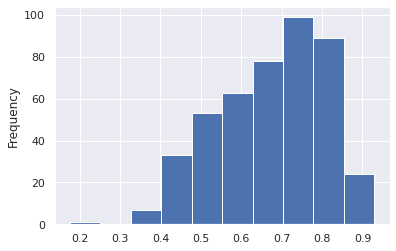

In [34]:
agg_on_chapter.answer.plot.hist()

## 시간(timestamp)에 따른 정답률 관찰
유의미하다고 볼 수 있는 것은 month & hour

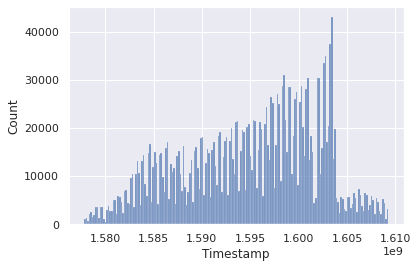

In [35]:
sns.histplot(train_df[train_df.label == "train"].Timestamp.astype(int) / 10**9)

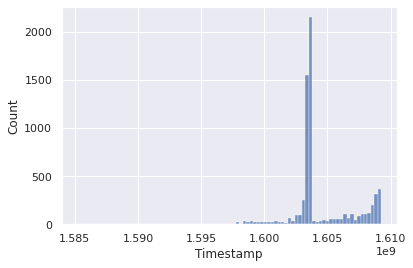

In [36]:
sns.histplot(valid_df.Timestamp.astype(int) / 10**9)

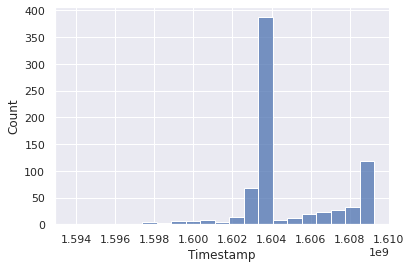

In [37]:
sns.histplot(test_df.Timestamp.astype(int) / 10**9)

In [38]:
agg_on_weekday = train_df.groupby(["weekday"]).agg({"answer": "mean"})
agg_on_month = train_df.groupby(["month"]).agg({"answer": "mean"})
agg_on_hour = train_df.groupby(["hour"]).agg({"answer": "mean"})
agg_on_day = train_df.groupby(["day"]).agg({"answer": "mean"})

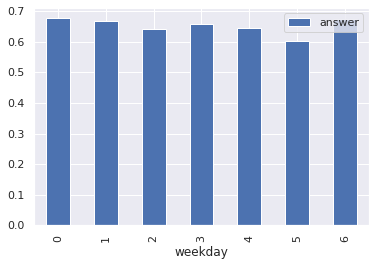

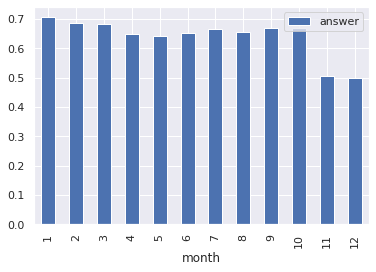

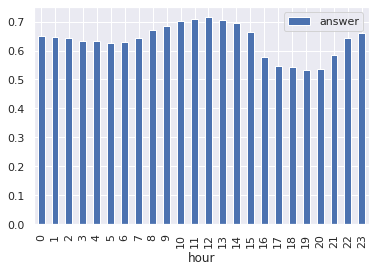

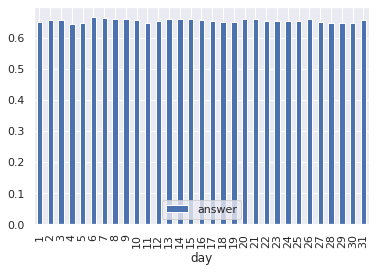

In [39]:
agg_on_weekday.plot.bar()
agg_on_month.plot.bar()
agg_on_hour.plot.bar()
agg_on_day.plot.bar()

## 이전 문제를 푸는데 걸린 시간: prev elapsed, prev test elapsed

In [40]:
prev_elapsed = train_df[["user", "Timestamp"]].groupby("user").diff()["Timestamp"].dt.seconds
prev_test_elapsed = train_df[["user", "testId", "Timestamp"]].groupby(["user", "testId"]).diff()["Timestamp"].dt.seconds

## 문제 번호에 따른 난이도
마지막 문항에 가까운 정도를 나타내는 feature == last_prob </br>
마지막 문제면 1, 마지막 문제에서 멀어질 수록 0에 가까움

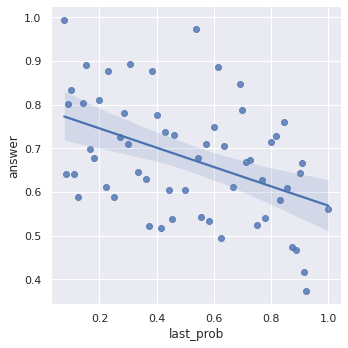

In [41]:
tmp = train_df.groupby(["testId"]).agg({"item": "max"})
tmp.rename(columns={"item": "last_prob_no"}, inplace=True)

tmp_df = train_df.copy()
tmp_df = pd.merge(tmp_df, tmp, on="testId", how="left")
tmp_df["last_prob"] = tmp_df["item"] / tmp_df["last_prob_no"]
tmp_df = tmp_df.drop("last_prob_no", axis=1)

last_prob_group = tmp_df.groupby("last_prob").agg({"answer": "mean"}).reset_index()
sns.lmplot(x="last_prob", y="answer", data=last_prob_group)

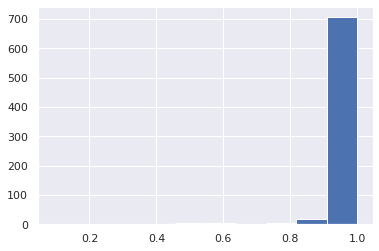

In [42]:
tmp = test_df.groupby(["testId"]).agg({"item": "max"})
tmp.rename(columns={"item": "last_prob_no"}, inplace=True)

tmp_df = test_df.copy()
tmp_df = pd.merge(tmp_df, tmp, on="testId", how="left")
tmp_df["last_prob"] = tmp_df["item"] / tmp_df["last_prob_no"]
tmp_df["last_prob"].hist()

## 시험지 번호에 따른 난이도

In [43]:
tmp = train_df.groupby(["category"]).agg({"test": "max"})
tmp.rename(columns={"test": "last_test_no"}, inplace=True)
# tmp
# df = pd.merge(df, tmp, on="category", how="left")
# df["test"] / df["last_test_no"]
# df = df.drop("last_test_no", axis=1)
tmp

,last_test_no
category,
1,192
2,195
3,198
4,198
5,193
6,186
7,164
8,138
9,74


## 반복적으로 푼 문제가 있는가?

In [44]:
user_prob_group = train_df.groupby(["user", "assessmentItemID"]).agg({"answer": "count"})
user_prob_group.rename(columns={"answer": "attempt"}, inplace=True)
user_prob_group.sort_values("attempt", ascending=False, inplace=True)

In [45]:
attempt_type = (train_df.groupby(["user", "assessmentItemID"])
                .cumcount()
                .apply(lambda x: "first attempt" if x == 0 else "repeated attempt"))
train_df["attempt_type"] = attempt_type

In [46]:
repeated_prob = train_df[train_df.attempt_type == "repeated attempt"].assessmentItemID.unique()

# 재시도한 문제들의 정답률
train_df.groupby("assessmentItemID").agg({"answer": "mean"}).loc[repeated_prob].mean().values[0]

0.6543927414476026

In [47]:
# np.unique(user_prob_group.answer, return_counts=True)
train_df[(train_df.user == 517) & (train_df.assessmentItemID == "A080127002")]

,user,assessmentItemID,testId,answer,Timestamp,tag,label,category,test,item,month,day,weekday,hour,elapsed,test_elapsed,chapter,attempt_type
418072,517,A080127002,A080000127,0,2020-11-12 04:48:45,2719,train,8,127,2,11,12,3,4,2.0,2.0,419,first attempt
418200,517,A080127002,A080000127,0,2020-12-07 23:49:04,2719,train,8,127,2,12,7,0,23,3.0,3.0,419,repeated attempt
418257,517,A080127002,A080000127,1,2020-12-16 04:49:48,2719,train,8,127,2,12,16,2,4,4.0,4.0,419,repeated attempt


## 최종적으로 맞춰야 하는 문제는 각 시험의 마지막 문제인가?
대체로 그렇다 (93%) <br>
그렇다면 train과 valid를 어떤 식으로 구성해야하는가? <br>
각 시험의 마지막 문제들을 푼 데이터를 다 valid로 => 학습 때는 마지막 문항들을 아예 보지도 못하고 valid에서 맞출 수 있을까? <br>
아니면 학습 데이터에 마지막 문제들을 푼 데이터를 여러번 넣는 것은? 혹은 마지막 문제가 아닌 애들 수 줄여서 비율을 1대 1로 가져가는 건? <br>

In [48]:
np.unique(tmp_df[tmp_df.answer == -1].last_prob, return_counts=True)

(array([0.09090909, 0.25      , 0.33333333, 0.375     , 0.5       ,
        0.625     , 0.66666667, 0.71428571, 0.75      , 0.8       ,
        0.83333333, 0.85714286, 0.875     , 1.        ]),
 array([  1,   1,   1,   2,   6,   4,   1,   1,   2,   2,   4,   2,  11,
        706]))

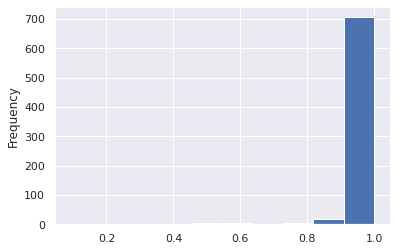

In [49]:
tmp_df[tmp_df.answer == -1].last_prob.plot.hist()

## submission data에 대한 EDA

In [50]:
test_data = train_df[train_df.label == "test"]
test_data

,user,assessmentItemID,testId,answer,Timestamp,tag,label,category,test,item,month,day,weekday,hour,elapsed,test_elapsed,chapter,attempt_type
1954,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,test,5,23,1,1,9,3,10,26.0,26.0,254,first attempt
1955,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,test,5,23,2,1,9,3,10,94.0,94.0,254,first attempt
1956,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,test,5,23,3,1,9,3,10,5.0,5.0,254,first attempt
1957,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,test,5,23,4,1,9,3,10,7.0,7.0,254,first attempt
1958,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,test,5,23,6,1,9,3,10,3.0,3.0,254,first attempt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526670,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,test,4,197,6,8,21,4,7,55658.0,NaN,245,first attempt
2526671,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,test,4,130,1,10,14,2,23,18.0,18.0,226,first attempt
2526672,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,test,4,130,2,10,14,2,23,21.0,21.0,226,first attempt
2526673,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,test,4,130,3,10,14,2,23,89.0,89.0,226,first attempt


In [51]:
(test_data.groupby(["user"])
 .agg({"assessmentItemID": "nunique",
       "testId": "nunique",
       "answer": "mean",
       
       "tag": "nunique",
       "chapter": "nunique"})
 .sort_values("assessmentItemID", ascending=False)
)

,assessmentItemID,testId,answer,tag,chapter
user,,,,,
584,1619,242,0.575664,350,119
1348,1378,205,0.486938,304,100
260,1334,212,0.688156,220,84
617,1332,223,0.828829,279,132
13,1316,206,0.695289,218,94
...,...,...,...,...,...
7033,14,3,0.214286,3,3
7404,14,3,0.500000,4,3
7416,14,3,0.500000,7,3


In [52]:
train_data = train_df[train_df.label == "train"]
(train_data.groupby(["user"])
 .agg({"assessmentItemID": "nunique",
       "testId": "nunique",
       "answer": "mean",
       
       "tag": "nunique",
       "chapter": "nunique"})
 .sort_values("assessmentItemID", ascending=False)
)
# train_data_first = train_data[train_data.user != train_data.user.shift(1)]

,assessmentItemID,testId,answer,tag,chapter
user,,,,,
730,1860,259,0.598387,270,90
481,1847,279,0.124526,235,108
1112,1777,281,0.656162,220,120
926,1773,301,0.875353,210,154
1600,1737,286,0.854347,167,114
...,...,...,...,...,...
7396,14,3,0.928571,9,3
7414,13,3,0.615385,4,3
7390,13,3,0.615385,3,3
